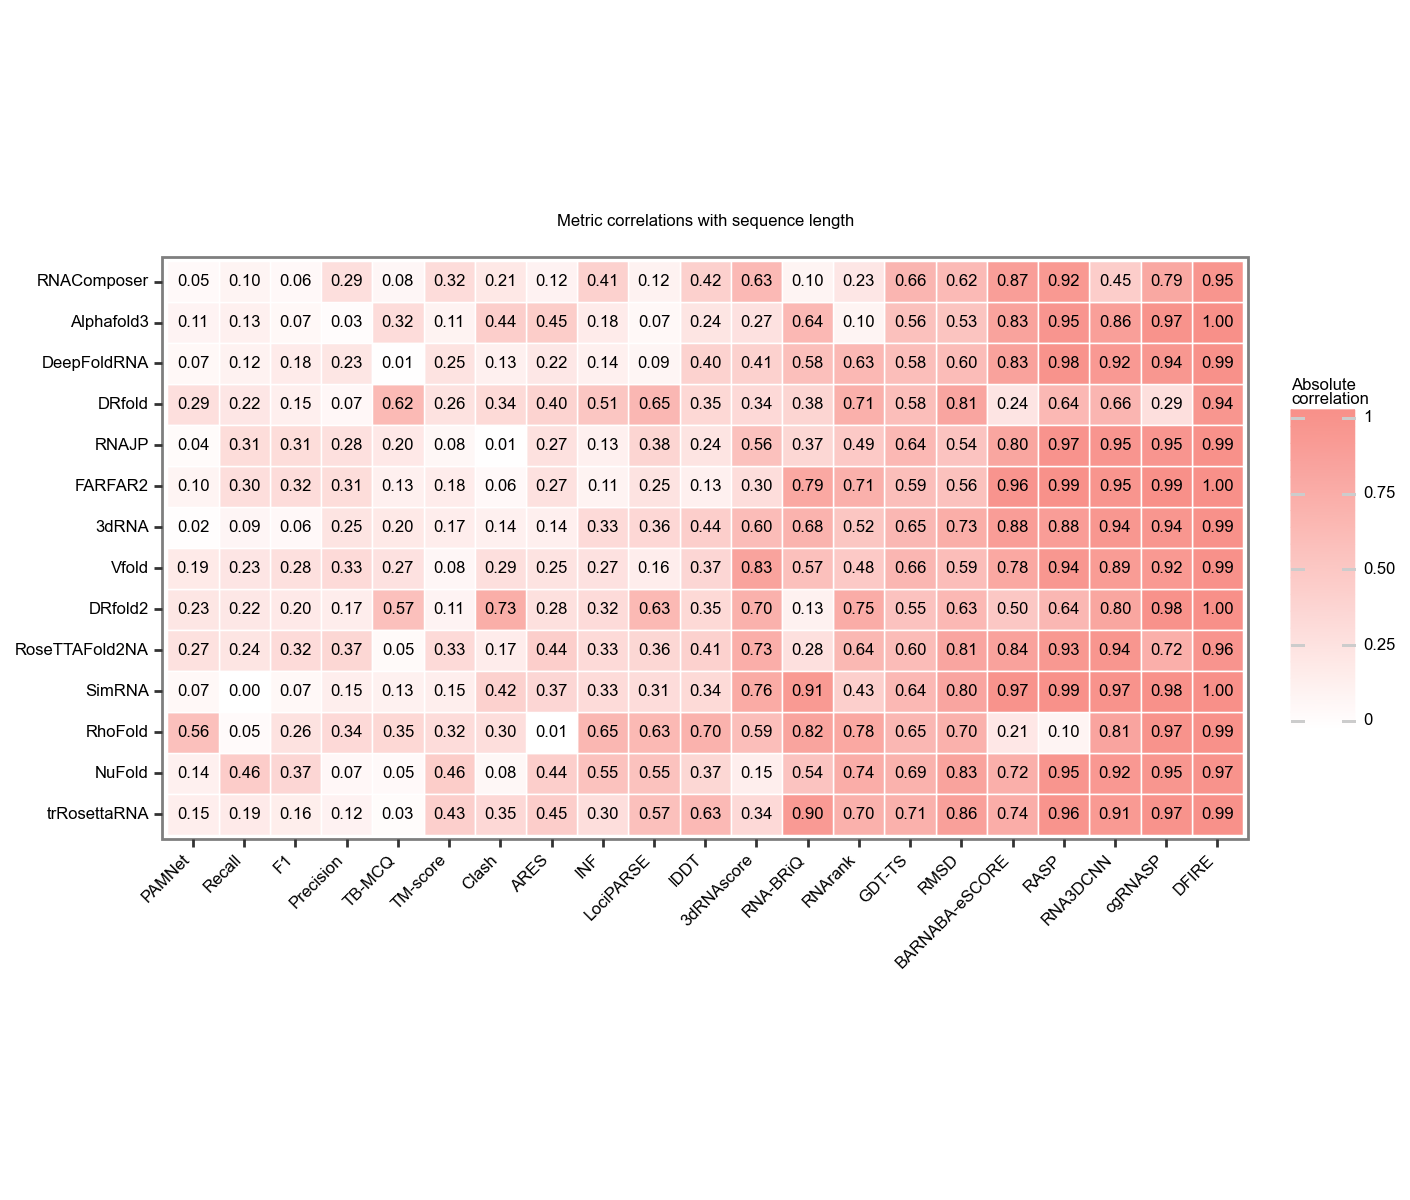

/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7.05 x 6 in image.
/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/metrics_correlation_with_sequence_length.pdf


In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Heatmap: absolute Pearson correlation between sequence length and each metric,
computed separately for each prediction method.

- Input: two merged CSVs with columns: method, length, and metric columns.
- Output: PDF heatmap suitable for publication.

Tested style: Python 3.8 + plotnine.
"""

from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from scipy import stats
from plotnine import (
    ggplot, aes, geom_tile, geom_text, theme_bw, theme,
    element_text, element_blank, labs, coord_fixed,
    scale_fill_gradient, guides
)


# -------------------------
# Configuration
# -------------------------
DATASET1 = Path("../results/metrics/dataset1_merge.csv")
DATASET2 = Path("../results/metrics/dataset2_merge.csv")
OUT_PDF = Path("../figures/metrics_correlation_with_sequence_length.pdf")

# Metrics (columns) to evaluate
FEATURES: List[str] = [
    "RMSD", "lddt", "TM-score", "GDT-TS", "LociPARSE", "RNArank",
    "INF-ALL", "f1", "precision", "recall",
    "BARNABA-eSCORE", "RNA3DCNN", "ARES", "tb_mcq", "PAMnet",
    "clash", "3drnascore", "RNA-BRiQ", "RASP-ENERGY", "DFIRE", "cgRNASP"
]

# Display names for the figure (publication labels)
FEATURE_LABELS: Dict[str, str] = {
    "RMSD": "RMSD",
    "lddt": "lDDT",
    "TM-score": "TM-score",
    "GDT-TS": "GDT-TS",
    "LociPARSE": "LociPARSE",
    "RNArank": "RNArank",
    "INF-ALL": "INF",
    "f1": "F1",
    "precision": "Precision",
    "recall": "Recall",
    "BARNABA-eSCORE": "BARNABA-eSCORE",
    "RNA3DCNN": "RNA3DCNN",
    "ARES": "ARES",
    "tb_mcq": "TB-MCQ",
    "PAMnet": "PAMNet",
    "clash": "Clash",
    "3drnascore": "3dRNAscore",
    "RNA-BRiQ": "RNA-BRiQ",
    "RASP-ENERGY": "RASP",
    "DFIRE": "DFIRE",
    "cgRNASP": "cgRNASP"
}

# Outlier trimming: keep values in [Q1 - k*IQR, Q3 + k*IQR]
IQR_K = 5.0

# Tile label format
LABEL_FMT = "{:.2f}"

# Font & layout (Nature-like: small, clean, consistent)
FONT_FAMILY = "Arial"
FONT_SIZE = 6  # pt-ish for plotnine; suitable for multi-panel figures


# -------------------------
# Utilities
# -------------------------
def require_columns(df: pd.DataFrame, cols: List[str]) -> None:
    """Raise a clear error if required columns are missing."""
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")


def iqr_bounds(x: pd.Series, k: float = 5.0) -> Tuple[float, float]:
    """Compute IQR-based bounds for outlier filtering."""
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (q1 - k * iqr, q3 + k * iqr)


def safe_pearsonr(x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    """
    Pearson correlation with edge-case handling.
    Returns (r, p). If not computable, returns (nan, nan).
    """
    if x.size < 2 or y.size < 2:
        return (np.nan, np.nan)
    # pearsonr raises if input is constant; catch and return nan
    try:
        r, p = stats.pearsonr(x, y)
        return (float(r), float(p))
    except Exception:
        return (np.nan, np.nan)


# -------------------------
# Main computation
# -------------------------
def build_heatmap_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute absolute Pearson r(length, metric) for each (method, metric),
    after per-metric outlier trimming.

    Returns a long-form DataFrame with columns:
    Method, Feature, abs_r, p, n
    """
    require_columns(df, ["method", "length"] + FEATURES)

    # Stable method order for reproducibility (avoid set() randomness)
    methods = sorted(df["method"].dropna().unique().tolist())

    rows = []
    for feat in FEATURES:
        low, high = iqr_bounds(df[feat], k=IQR_K)

        # Filter once per feature (faster + consistent bounds across methods)
        df_feat = df.loc[
            (df[feat] >= low) & (df[feat] <= high),
            ["method", "length", feat]
        ].dropna()

        for m in methods:
            sub = df_feat[df_feat["method"] == m]
            n = int(sub.shape[0])

            r, p = safe_pearsonr(sub["length"].to_numpy(), sub[feat].to_numpy())
            rows.append({
                "Method": m,
                "Feature_raw": feat,
                "Feature": FEATURE_LABELS.get(feat, feat),
                "n": n,
                "r": r,
                "abs_r": np.abs(r) if np.isfinite(r) else np.nan,
                "p": p
            })

    out = pd.DataFrame(rows)

    # Reorder axes by mean absolute correlation
    method_order = (out.groupby("Method")["abs_r"]
                    .mean()
                    .sort_values(ascending=False)
                    .index.tolist())

    feature_order = (out.groupby("Feature")["abs_r"]
                     .mean()
                     .sort_values(ascending=True)
                     .index.tolist())

    out["Method"] = pd.Categorical(out["Method"], categories=method_order, ordered=True)
    out["Feature"] = pd.Categorical(out["Feature"], categories=feature_order, ordered=True)

    # Precompute tile labels (plotnine best practice: no pandas ops inside aes)
    out["label"] = out["abs_r"].map(lambda v: "" if pd.isna(v) else LABEL_FMT.format(v))
    out.loc[out["n"] < 2, "label"] = ""  # hide labels when correlation isn't meaningful

    return out


# -------------------------
# Plotting
# -------------------------
def plot_heatmap(heatmap_df: pd.DataFrame):
    """
    Generate a publication-style heatmap using plotnine.
    - Fill: abs_r in [0, 1]
    - Label: abs_r formatted to 2 decimals
    """
    p = (
        ggplot(heatmap_df, aes(x="Feature", y="Method", fill="abs_r"))
        + geom_tile(color="white", size=0.3)
        + geom_text(aes(label="label"), size=6, family=FONT_FAMILY, color="black")
        + scale_fill_gradient(
            low="white",
            high="#F89089",
            limits=[0, 1],
            name="Absolute\ncorrelation"
        )
        + theme_bw()
        + theme(
            figure_size=(7.05, 6),  # inches; adjust for your multi-panel layout
            axis_text_x=element_text(
                rotation=45, hjust=1, size=FONT_SIZE, family=FONT_FAMILY, color="black"
            ),
            axis_text_y=element_text(
                size=FONT_SIZE, family=FONT_FAMILY, color="black"
            ),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            panel_grid=element_blank(),
            legend_title=element_text(size=FONT_SIZE, family=FONT_FAMILY),
            legend_text=element_text(size=FONT_SIZE, family=FONT_FAMILY),
            plot_title=element_text(hjust=0.5, size=FONT_SIZE, family=FONT_FAMILY, color="black"),
        )
        + labs(title="Metric correlations with sequence length")
        + coord_fixed(ratio=0.8)
        #+ guides(fill=True)   # set to False if you want legend off
    )
    return p


# -------------------------
# Script entry
# -------------------------
def main():
    # Load
    df1 = pd.read_csv(DATASET1, index_col=0)
    df2 = pd.read_csv(DATASET2, index_col=0)

    # Merge (keep original index if meaningful; otherwise ignore_index=True)
    df = pd.concat([df1, df2], axis=0)

    # Compute heatmap table
    heatmap_df = build_heatmap_dataframe(df)

    # Plot
    p = plot_heatmap(heatmap_df)
    print(p)

    # Save (vector PDF is typically preferred for journals)
    OUT_PDF.parent.mkdir(parents=True, exist_ok=True)
    p.save(str(OUT_PDF), dpi=300)

    # If you want to inspect data used for plotting:
    # heatmap_df.to_csv("../results/metrics/heatmap_abs_corr_length.tsv", sep="\t", index=False)


if __name__ == "__main__":
    main()
